# 1. Setup

## 1.2 Import Dependencies

In [5]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [6]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [8]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [9]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

In [10]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    try:
        for file in os.listdir(os.path.join('lfw', directory)):
            EX_PATH = os.path.join('lfw', directory, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)
    except:
        continue

In [11]:
# Import uuid library to generate unique image names
import uuid

In [12]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\a6bdfea4-f3cc-11ee-a7ba-973b43a59e11.jpg'

In [13]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

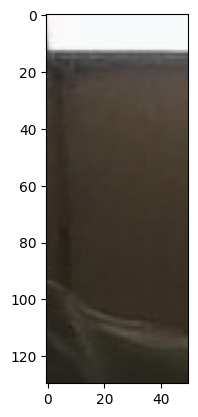

In [14]:
plt.imshow(frame[120:120+250,200:200+250, :])

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [15]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(600)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(600)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(600)

In [16]:
dir_test = anchor.as_numpy_iterator()

In [17]:
print(dir_test.next())

b'data\\anchor\\bc10fdaf-f3cc-11ee-9442-973b43a59e11.jpg'


## 3.2 Preprocessing - Scale and Resize

In [18]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [22]:
img = preprocess('./data/positive/c1b9fb49-f3cc-11ee-b2b7-973b43a59e11.jpg')

In [23]:
img.numpy().max() 

1.0

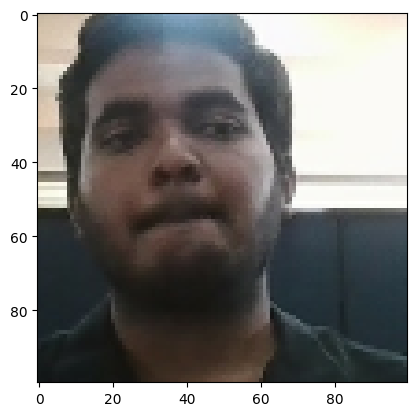

In [24]:
plt.imshow(img)

## 3.3 Create Labelled Dataset

In [25]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [26]:
samples = data.as_numpy_iterator()

In [27]:
exampple = samples.next()

In [28]:
exampple

(b'data\\anchor\\bc1f5f2a-f3cc-11ee-8c63-973b43a59e11.jpg',
 b'data\\positive\\ca622d46-f3cc-11ee-ae62-973b43a59e11.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [29]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [30]:
res = preprocess_twin(*exampple)

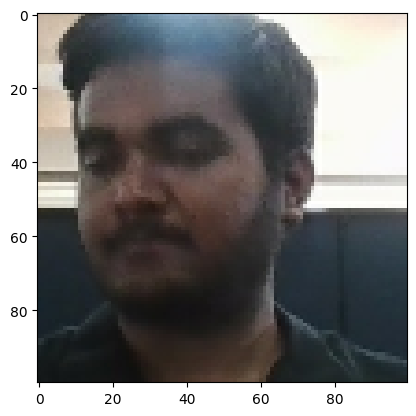

In [31]:
plt.imshow(res[1])

In [32]:
res[2]

1.0

In [33]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [34]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [35]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

In [36]:
import tensorflow as tf
import keras

def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')

    # Convolutional blocks for feature extraction
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

# Define the L1 Distance layer
class L1Dist(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding[0] - validation_embedding[0])

# Create the Siamese network
embedding = make_embedding()  # Define the embedding network
input_image = Input(name='input_img', shape=(100, 100, 3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)

siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

# 5. Training

## 5.1 Setup Loss and Optimizer

In [37]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [38]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [39]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_network)

## 5.3 Build Train Step Function

In [40]:
test_batch = train_data.as_numpy_iterator()

In [41]:
batch_1 = test_batch.next()

In [42]:
X = batch_1[:2]

In [43]:
y = batch_1[2]

In [44]:
y

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
      dtype=float32)

In [45]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_network(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_network.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_network.trainable_variables))
    
    # Return loss
    return loss

## 5.4 Build Training Loop

In [46]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [48]:
EPOCHS = 50

In [49]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
16/17 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
17/17 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step

 Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step

 Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step

 Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step

 Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step

 Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step

 Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step

 Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step

 Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step

 Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step

 Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step

 Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step

 Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step

 Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3327s 208s/step

 Epoch 15/50
17/17 ━━━━━━━━━━━

# 6. Evaluate Model

## 6.1 Import Metrics

In [50]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [51]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [52]:
# Make predictions
y_hat = siamese_network.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


array([[1.0709825e-06],
       [1.8612441e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.5476024e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9965173e-01],
       [1.0000000e+00],
       [5.3404647e-10],
       [9.9970317e-01],
       [9.9904674e-01],
       [9.9999952e-01],
       [1.0000000e+00],
       [7.2296286e-15],
       [1.6792832e-13]], dtype=float32)

In [53]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0]

In [54]:
y_true

array([0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [55]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [56]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

## 6.4 Viz Results

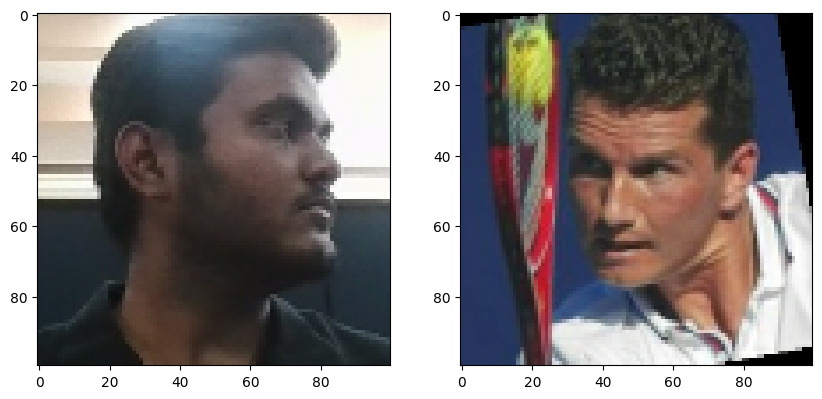

In [57]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [58]:
# Save weights
siamese_network.save('siamesemodel.keras')

In [59]:
L1Dist

__main__.L1Dist

In [60]:
# Reload model 

model = tf.keras.models.load_model('siamesemodel.keras', custom_objects={'L1Dist':L1Dist})

In [61]:
# Make predictions with reloaded model
siamese_network.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


array([[1.0709825e-06],
       [1.8612441e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.5476024e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9965173e-01],
       [1.0000000e+00],
       [5.3404647e-10],
       [9.9970317e-01],
       [9.9904674e-01],
       [9.9999952e-01],
       [1.0000000e+00],
       [7.2296286e-15],
       [1.6792832e-13]], dtype=float32)

In [62]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)